## Imports and Setups

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import polars as pl
from pathlib import Path
import subprocess

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib_venn import venn3

## Data Loading

In [2]:
DORADO_FILE = Path('../Exemplar_Data/parquet_files/Dorado_filtered_20_20_17802.parquet')

DATA_URLS = {
    'bid_seq': 'https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE179798&format=file&file=GSE179798_HEK293T_mRNA_WT_BID-seq.xlsx',
    'praise': 'https://static-content.springer.com/esm/art%3A10.1038%2Fs41589-023-01304-7/MediaObjects/41589_2023_1304_MOESM3_ESM.xlsx'
}

DATA_DIR = Path("../Exemplar_Data/orthogonal_data")
DATA_DIR.mkdir(parents=True, exist_ok=True)

for name, url in DATA_URLS.items():
    output_file = DATA_DIR / Path(url).name
    if not output_file.exists():
        subprocess.run(['wget', '-q', '-O', str(output_file), url], check=True)

PSI_BIDSEQ_FILE = DATA_DIR / "GSE179798_HEK293T_mRNA_WT_BID-seq.xlsx"
PSI_PRAISE_FILE = DATA_DIR / "41589_2023_1304_MOESM3_ESM.xlsx"

In [3]:
from typing import Union, Any
import gzip
import pickle

class OrthogonalDataloader:
    def __init__(self, file_path: Union[Path, str]) -> None:
        self.file_path = Path(file_path)
        if not self.file_path.is_file():
            raise FileNotFoundError(f"File not found: '{self.file_path}'")

    def load_data(self, **kwargs: Any) -> Union[pd.DataFrame, dict, Any]:
        suffixes = self.file_path.suffixes
        compression = 'gzip' if '.gz' in suffixes else None
        
        try:
            if '.pkl' in suffixes:
                if compression == 'gzip':
                    with gzip.open(self.file_path, 'rb') as f:
                        return pickle.load(f, **kwargs)
                else:
                    with open(self.file_path, 'rb') as f:
                        return pickle.load(f, **kwargs)
            
            elif '.xlsb' in suffixes or '.xlsx' in suffixes:
                if 'sheet_name' not in kwargs:
                    kwargs['sheet_name'] = None
                engine = 'pyxlsb' if '.xlsb' in suffixes else None
                return pd.read_excel(self.file_path, engine=engine, **kwargs)

            elif '.csv' in suffixes:
                return pd.read_csv(self.file_path, compression=compression, **kwargs)

            elif '.tsv' in suffixes or '.txt' in suffixes:
                if 'sep' not in kwargs:
                    kwargs['sep'] = '\t'
                return pd.read_csv(self.file_path, compression=compression, **kwargs)

            else:
                raise ValueError(f"Unsupported file type: {''.join(suffixes)}")
        
        except Exception as e:
            print(f"Failed to load {self.file_path.name}: {e}")
            return None

## Load All Data for Plotting

In [4]:
hek293_psi_drs = pl.read_parquet(DORADO_FILE)

# BID-Seq
loader = OrthogonalDataloader(PSI_BIDSEQ_FILE)
bid_raw = loader.load_data()
bid_seq_df = bid_raw['Sheet1'] if isinstance(bid_raw, dict) else bid_raw
bid_seq_df.columns = bid_seq_df.iloc[2]
bid_seq_df = bid_seq_df[3:].reset_index(drop=True)

# PRAISE-Seq
loader = OrthogonalDataloader(PSI_PRAISE_FILE)
praise_raw = loader.load_data()

if isinstance(praise_raw, dict):
    praise_df = None
    for sheet_name in praise_raw.keys():
        if ('dataset 2' in sheet_name.lower() or 
            'supplementary dataset 2' in sheet_name.lower()):
            praise_df = praise_raw[sheet_name]
            break
    if praise_df is None:
        raise ValueError("PRAISE sheet not found")
else:
    praise_df = praise_raw

praise_df.columns = praise_df.iloc[1]
praise_df = praise_df[2:].reset_index(drop=True)

if 'chr_name' in praise_df.columns:
    praise_df['accession'] = praise_df['chr_name'].astype(str)
    praise_df = praise_df[
        praise_df['accession'].str.startswith('NM_') | 
        praise_df['accession'].str.startswith('XM_')
    ].copy()

def parse_chr_site(chr_site_str):
    try:
        if pd.isna(chr_site_str):
            return None, None
        chr_site_str = str(chr_site_str).strip()
        if '_' not in chr_site_str:
            return None, None
        parts = chr_site_str.split('_')
        if len(parts) != 2:
            return None, None
        chrom = parts[0].strip()
        pos_part = parts[1].strip()
        if '-' in pos_part:
            pos = pos_part.split('-')[0].strip()
        else:
            pos = pos_part.strip()
        try:
            pos = int(pos)
        except ValueError:
            return chrom, None
        return chrom, pos
    except Exception:
        return None, None

if 'chr_site' in praise_df.columns:
    parsed = praise_df['chr_site'].apply(parse_chr_site)
    praise_df['chromosome'] = [x[0] for x in parsed]
    praise_df['genomic_position'] = [x[1] for x in parsed]
    
    praise_filtered = praise_df[
        (praise_df['chromosome'].notna()) & 
        (praise_df['genomic_position'].notna())
    ].copy()
    
    if 'gene_name' in praise_filtered.columns:
        praise_filtered = praise_filtered[
            (~praise_filtered['gene_name'].str.contains('trna', case=False, na=False)) &
            (~praise_filtered['gene_name'].str.contains('rrna', case=False, na=False))
        ]

## Helper Functions

In [5]:
from typing import Set

def get_drs_sites(df: pl.DataFrame) -> Set[str]:
    df_filtered = df.filter((pl.col('IVT_Adjusted_Mod_Percent') >= 20) & (pl.col('Score') >= 20))
    
    sample_chr = df_filtered['Chromosome'][0] if len(df_filtered) > 0 else None
    if sample_chr and not str(sample_chr).startswith('chr'):
        sites = set(('chr' + df_filtered['Chromosome'].cast(pl.Utf8) + '_' + 
                    df_filtered['End'].cast(pl.Int64).cast(pl.Utf8)).to_list())
    else:
        sites = set((df_filtered['Chromosome'].cast(pl.Utf8) + '_' + 
                    df_filtered['End'].cast(pl.Int64).cast(pl.Utf8)).to_list())
    return sites

def process_orthogonal_sites(df, chr_col: str, pos_col: str) -> Set[str]:
    if df is None:
        return set()
    
    sample_chr = str(df[chr_col].iloc[0]) if len(df) > 0 else None
    pos_int = df[pos_col].astype(float).astype(int).astype(str)
    if sample_chr and sample_chr.startswith('chr'):
        sites = set(df[chr_col].astype(str) + '_' + pos_int)
    else:
        sites = set('chr' + df[chr_col].astype(str) + '_' + pos_int)
    return sites

In [6]:
drs_sites = get_drs_sites(hek293_psi_drs)
bid_sites = process_orthogonal_sites(bid_seq_df, 'chr', 'pos')
praise_sites = process_orthogonal_sites(praise_filtered, 'chromosome', 'genomic_position')

print(f"HEK293 DRS: {len(drs_sites):,} sites")
print(f"BID-seq: {len(bid_sites):,} sites")
print(f"PRAISE: {len(praise_sites):,} sites")
print(f"All three overlap: {len(drs_sites & bid_sites & praise_sites):,}")

HEK293 DRS: 2 sites
BID-seq: 543 sites
PRAISE: 1,774 sites
All three overlap: 0


## Plotting

In [7]:
PSI_COLORS = {
    'DRS_HEK293': '#9467bd',
    'BID-seq': '#8c564b',
    'PRAISE': '#ff7f0e',
    'HEK_BID': '#bcbd22',
    'HEK_PRAISE': '#17becf',
    'BID_PRAISE': '#e377c2',
    'ALL_THREE': '#7f7f7f',
}

ALPHA = 0.7

print("✓ Color scheme loaded")

✓ Color scheme loaded


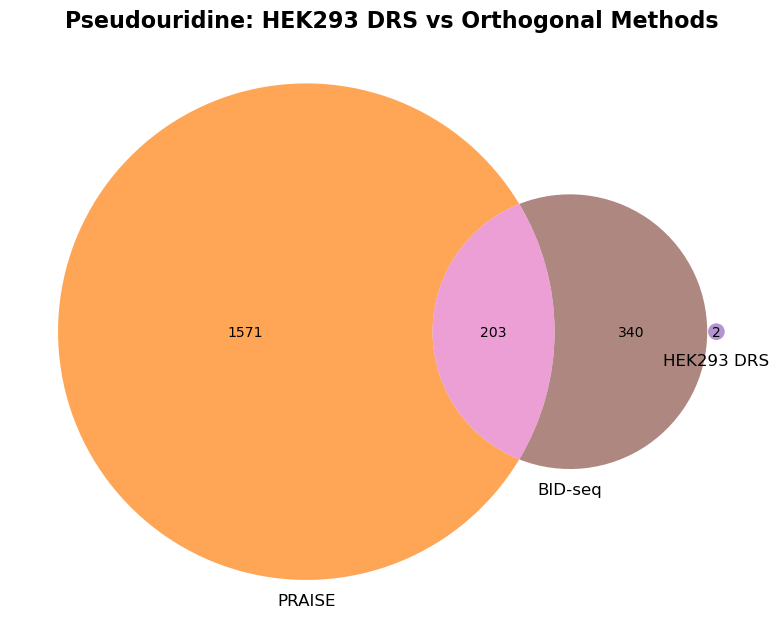

In [8]:
fig, ax = plt.subplots(figsize=(8, 8))

venn = venn3([drs_sites, praise_sites, bid_sites],
             set_labels=['HEK293 DRS', 'PRAISE', 'BID-seq'])

patch_colors = {
    '100': PSI_COLORS['DRS_HEK293'],
    '010': PSI_COLORS['PRAISE'],
    '001': PSI_COLORS['BID-seq'],
    '110': PSI_COLORS['HEK_PRAISE'],
    '101': PSI_COLORS['HEK_BID'],
    '011': PSI_COLORS['BID_PRAISE'],
    '111': PSI_COLORS['ALL_THREE']
}

for region_id, color in patch_colors.items():
    patch = venn.get_patch_by_id(region_id)
    if patch:
        patch.set_facecolor(color)
        patch.set_alpha(ALPHA)

ax.set_title('Pseudouridine: HEK293 DRS vs Orthogonal Methods', 
             fontweight='bold', fontsize=16)

plt.tight_layout()
plt.show()

In [9]:
print("="*70)
print("Overlap Statistics:")
print("="*70)
print(f"DRS only: {len(drs_sites - praise_sites - bid_sites):,}")
print(f"PRAISE only: {len(praise_sites - drs_sites - bid_sites):,}")
print(f"BID-seq only: {len(bid_sites - drs_sites - praise_sites):,}")
print(f"DRS ∩ PRAISE: {len(drs_sites & praise_sites - bid_sites):,}")
print(f"DRS ∩ BID-seq: {len(drs_sites & bid_sites - praise_sites):,}")
print(f"PRAISE ∩ BID-seq: {len(praise_sites & bid_sites - drs_sites):,}")
print(f"All three: {len(drs_sites & praise_sites & bid_sites):,}")
print(f"Total unique sites: {len(drs_sites | praise_sites | bid_sites):,}")

Overlap Statistics:
DRS only: 2
PRAISE only: 1,571
BID-seq only: 340
DRS ∩ PRAISE: 0
DRS ∩ BID-seq: 0
PRAISE ∩ BID-seq: 203
All three: 0
Total unique sites: 2,116
